In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

In [63]:
def mutal_capacitance_adjacent_spheres(eps_r: float, np_radius1: float, np_radius2: float, np_distance: float)->float:

    d       = (np_radius1 + np_radius2 + np_distance)
    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_r*(np_radius1*np_radius2)/d
    sum_val = sum([1,(np_radius1*np_radius2)/(d**2-2*np_radius1*np_radius2),
                    ((np_radius1**2)*(np_radius2**2))/(d**4-4*(d**2)*np_radius1*np_radius2+3*(np_radius1**2)*(np_radius2**2))])
    cap     = factor*sum_val

    return np.round(cap,2)*1e-18

def self_capacitance_sphere(eps_s: float, np_radius: float)->float:

    factor  = 4*3.14159265359*8.85418781762039*0.001*eps_s
    cap     = factor*np_radius

    return np.round(cap,2)*1e-18

def characteristic_time_mode(n: int, R: float, Cm: float, Cs: float, N: int, closed: bool)->float:
    """Characteristic Time of mode n in a string of N Nanoparticles

    Parameters
    ----------
    n : int
        nth mode [1,N]
    R : float
        Junction resistance
    Cm : float
        Mutual capacitance
    Cs : float
        Self capacitance
    N : int
        Number of Nanoparticles in String
    closed : bool
        If last not is grounded or not

    Returns
    -------
    float
        Characteristic mode time scale
    """
    if closed:
        a   = R*(Cs+2*Cm*(1-np.cos(n*np.pi/(N+1))))
        b   = 2*(1-np.cos(n*np.pi/(N+1)))
    else:
        a   = R*(Cs+2*Cm*(1-np.cos((2*n-1)*np.pi/(2*N))))
        b   = 4*np.sin((2*n-1)*np.pi/(2*N))**2
    return a/b

def solve_a_values(U0: float, N: int)->np.ndarray:

    i_vals  = np.arange(1, N + 1)
    n_vals  = np.arange(1, N + 1)
    S       = np.array([[np.sin(n * np.pi * i / (N + 1)) for n in n_vals] for i in i_vals])
    rhs     = -U0 * (1 - i_vals / (N + 1))
    return np.linalg.solve(S, rhs)

def solve_a_values_analytical(U0: float, N: int, closed: bool) -> np.ndarray:

    i_vals  = np.arange(1, N + 1)
    a_n     = np.zeros(N)

    if closed:
        for n in range(1, N + 1):
            sin_terms   = np.sin(n * np.pi * i_vals / (N + 1))
            weight      = 1 - i_vals / (N + 1)
            a_n[n - 1]  = - (2 * U0 / (N + 1)) * np.sum(weight * sin_terms)
    else:
        for n in range(1, N + 1):
            cos_terms   = np.cos((2*n-1)*np.pi*i_vals/(2*N))
            weight      = 2*

    return a_n

def node_potential(t_values: np.ndarray, a_n: np.ndarray, tau_n: np.ndarray, U0: float):
    
    N = len(a_n)
    i_values = np.arange(1, N + 1)[:, None]  # Shape (N, 1)
    t_values = np.array(t_values)[None, :]  # Shape (1, T)

    # First term: U0 * (1 - i / (N + 1)) for each i
    steady_part = U0 * (1 - i_values / (N + 1))  # Shape (N, 1)

    # Precompute sin matrix: sin(n * pi * i / (N+1))
    sin_matrix = np.array([
        [np.sin(n * np.pi * i / (N + 1)) for n in range(1, N + 1)]
        for i in range(1, N + 1)
    ])  # Shape (N, N)

    # Exponential decay for each n and each t
    exp_decay = np.exp(-t_values / tau_n[:, None])  # Shape (N, T)

    # Multiply a_n * exp_decay for each n, then sum over n weighted by sin
    dynamic_part = sin_matrix @ (a_n[:, None] * exp_decay)  # Shape (N, T)

    # Add steady part (broadcasted) and return full U(i, t)
    U = steady_part + dynamic_part  # Shape (N, T)
    return U  # Each row: i, each column: time

In [61]:
# Parameters
N_steps     = 40000
Np          = 50
R           = 25*1e6
U0          = 1.0
Cm          = mutal_capacitance_adjacent_spheres(2.6, 10, 10, 1)
Cs          = self_capacitance_sphere(3.9, 10)
n_v         = np.arange(1,Np+1)
tau_n       = mode_time_scale_theory(n_v, R, Cm, Cs, Np)
# a_vals      = solve_a_values_analytical(U0, Np)
a_vals      = solve_a_values(U0, Np)
t_vals      = np.arange(N_steps)*1e-10
phi         = node_potential(t_vals, a_vals, tau_n, U0)
tau_i_n0    = mode_time_scale_theory(1, R, Cm, Cs, np.arange(2,50))

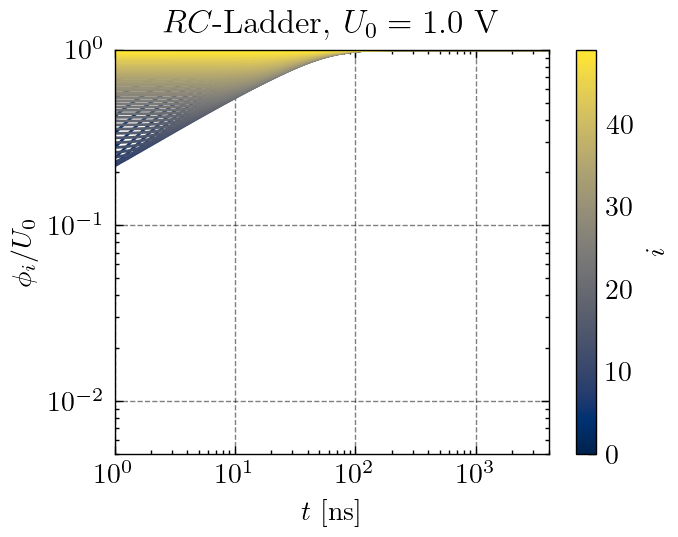

In [62]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=49)

for i in range(Np):
    ax.plot(t_vals*1e9, phi[i,:]/U0, color=cm(norm(i)))

ax.set_xlim(1,4000)
ax.set_ylim(0.005,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")
ax.set_title(f"$RC$-Ladder, $U_0 = {U0}$ V")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

Text(0.5, 0, '$n$')

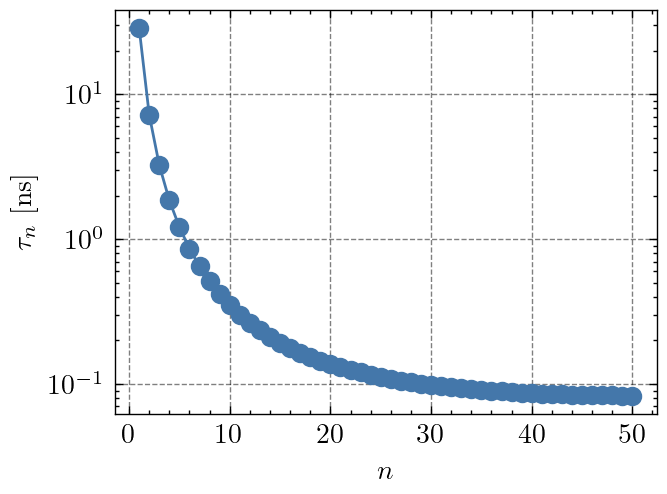

In [50]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(n_v,tau_n*1e9, '-o')
ax.set_yscale('log')
ax.set_ylabel("$\\tau_n$ [ns]")
ax.set_xlabel("$n$")

Text(0.5, 0, '$n$')

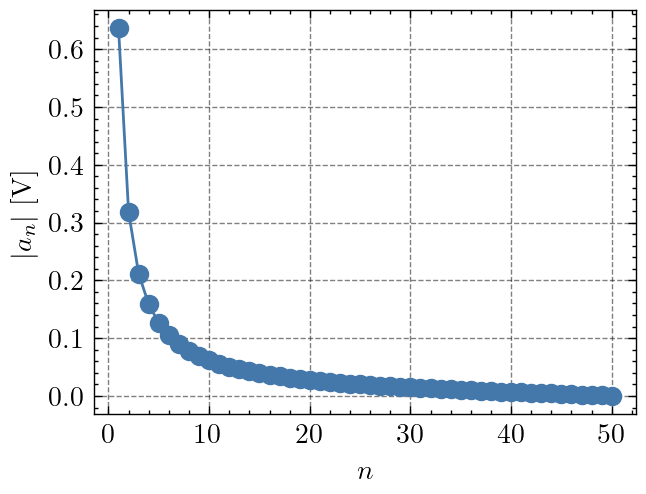

In [51]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
# ax.plot(n_v,a_vals)
ax.plot(n_v,np.abs(a_vals), '-o')
ax.set_ylabel("$|a_n|$ [V]")
ax.set_xlabel("$n$")

Text(0.5, 0, '$i$')

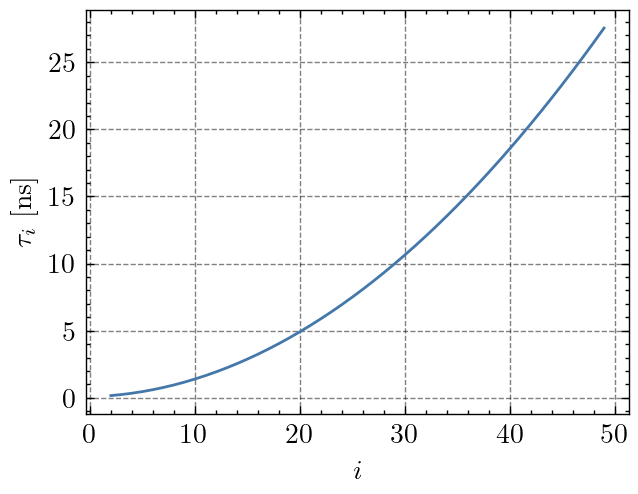

In [54]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(np.arange(2,50), tau_i_n0*1e9)
ax.set_ylabel("$\\tau_i$ [ns]")
ax.set_xlabel("$i$")

In [ ]:
def tau_i(i, N, R, Cm)

In [101]:
total   = 0.0
for n in range(1,N+1):
    weights = (a_vals[n-1] * np.sin(n * np.pi * i /(N + 1)))**2

array([-2.22067821e+07, -4.40713032e+07, -6.52663564e+07, -8.54934698e+07,
       -1.04494052e+08, -1.22057214e+08, -1.38023924e+08, -1.52287623e+08,
       -1.64791749e+08, -1.75524897e+08, -1.84514397e+08, -1.91819102e+08,
       -1.97522041e+08, -2.01723455e+08, -2.04534554e+08, -2.06072205e+08,
       -2.06454593e+08, -2.05797852e+08, -2.04213575e+08, -2.01807086e+08,
       -1.98676341e+08, -1.94911345e+08, -1.90593948e+08, -1.85797938e+08,
       -1.80589334e+08, -1.75026809e+08, -1.69162210e+08, -1.63041102e+08,
       -1.56703338e+08, -1.50183613e+08, -1.43511998e+08, -1.36714439e+08,
       -1.29813227e+08, -1.22827416e+08, -1.15773215e+08, -1.08664333e+08,
       -1.01512292e+08, -9.43267047e+07, -8.71155216e+07, -7.98852515e+07,
       -7.26411555e+07, -6.53874196e+07, -5.81273079e+07, -5.08632983e+07,
       -4.35972039e+07, -3.63302820e+07, -2.90633315e+07, -2.17967825e+07,
       -1.45307786e+07, -7.26525269e+06])

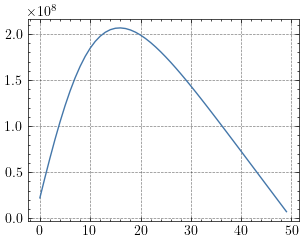

In [103]:
plt.plot(np.abs(a_vals)/tau_n)